In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

import time
import pandas as pd

%config InlineBackend.figure_format = "retina"
%matplotlib inline

In [2]:
data = pd.read_csv("EIG.txt", delimiter="\s+", header=0)

y = data["recorded-EIG121"].values
y = y[~np.isnan(y)]
y = np.log(y)

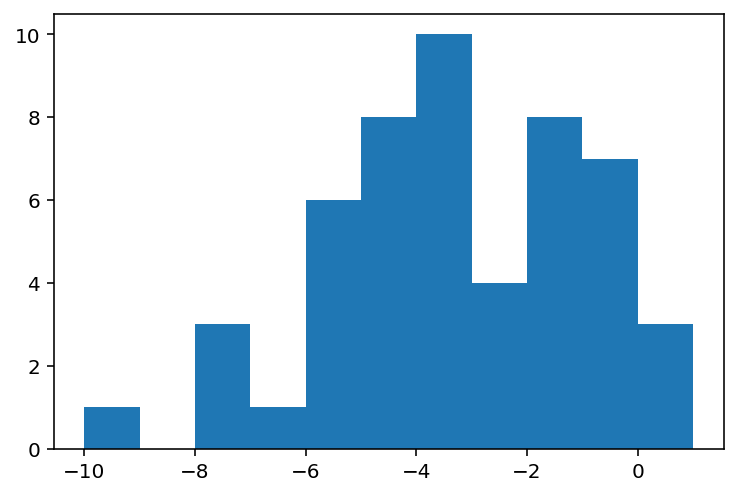

In [3]:
_ = plt.hist(y, bins=11, range=(-10, 1))

In [4]:
rng = np.random.RandomState(seed=34)
NUM_ITER = 1000
B = 100

M = 5
m = -5; B = 10
sigma_sq = 3 # known variance
a = 1; b = 1

x_grid = np.linspace(start=-10, stop=1, num=1001)

In [5]:
G0 = lambda: rng.normal(loc=-5, scale=np.sqrt(B))

def h(yi):
    return norm.pdf(yi, loc=m, scale=np.sqrt(B + sigma_sq))

# def sample_sigma_sq(thetas, rng=rng):
#     s2 = np.sum((y - thetas)**2)
#     a1 = a + 0.5*len(thetas)
#     b1 = b + 0.5*s2

#     s2_inv = rng.gamma(shape=1, scale=b1)
    
#     return 1/s2_inv

def sample_s(yi, y_minus, s_minus, G0, rng=rng):
    
    global prob
    prob = []
    
    for urn_id in np.unique(s_minus):
        nj_minus = np.sum(s_minus == urn_id)
        Vj_minus = 1/(1/B + nj_minus/sigma_sq)
        mj_minus = Vj_minus*(m/B + np.sum(y_minus[s_minus == urn_id])/sigma_sq)

        prob = np.append(
            prob, 
            nj_minus*norm.pdf(yi, loc=mj_minus, scale=np.sqrt(Vj_minus + sigma_sq)),
        )
    
    prob = np.append(prob, M*h(yi)) # compute hyi
    prob = prob/prob.sum()

    s_draw = rng.choice(range(len(prob)), p=prob)
    
    assert len(theta_star_minus) == len(np.unique(s_minus))
    
    if s_draw == len(theta_star_minus):
        return G0()
    
    else:
        return theta_star_minus[s_draw]
    

def sample_theta_star(yj_star_minus, G0=G0, rng=rng):
    """
    yj_star: array of observations assigned to urn j
    """
    nj_minus = len(yj_star_minus)
    
    if nj_minus == 0:
        return G0()
    
    return rng.normal( 
        loc=(B*np.sum(yj_star_minus) + sigma_sq*m)/(nj_minus*B + sigma_sq), 
        scale=np.sqrt((B*sigma_sq)/(nj_minus*B + sigma_sq)),
    )


def sample_density(grid, thetas):
    f = []
    for x in grid:
        f.append(norm.pdf(x, loc=thetas, scale=np.sqrt(sigma_sq)).sum()/len(thetas))
        
    return f

In [6]:
thetas = np.round(y)
unique_clusters = []
n = len(y)

theta_acc = np.empty(shape=(NUM_ITER + B, n))
f_acc = np.empty(shape=(NUM_ITER + B, x_grid.shape[0]))

start = time.time()

for _iter in range(NUM_ITER):
    
    i_indices = rng.choice(a=range(n), size=n, replace=False)
    
    for i in i_indices:
        yi = y[i]
        
        theta_minus = np.delete(thetas, i)
        y_minus = np.delete(y, i)
        
        theta_star_minus, s_minus = np.unique(
            theta_minus, 
            return_inverse=True,
        )

        thetas[i] = sample_s(yi, y_minus, s_minus, G0)
    
    theta_star, s = np.unique(thetas, return_inverse=True)
    
    k = len(theta_star)
    j_indices = rng.choice(a=range(k), size=k, replace=False)
    
    for j in j_indices:
        # sample theta_star
        theta_j = theta_star[j]
        thetas[thetas == theta_j] = sample_theta_star(y[thetas == theta_j])
        
    unique_clusters.append(len(np.unique(thetas)))
    
    if _iter % 100 == 0:
        print(f"Finished {_iter} iterations")
    
    f_acc[_iter] = sample_density(x_grid, thetas)
    theta_acc[_iter] = thetas
    
print(f"\nMCMC sampling took {np.around((time.time() - start)/60, 2)} minutes to complete")

Finished 0 iterations
Finished 100 iterations
Finished 200 iterations
Finished 300 iterations
Finished 400 iterations
Finished 500 iterations
Finished 600 iterations
Finished 700 iterations
Finished 800 iterations
Finished 900 iterations

MCMC sampling took 3.49 minutes to complete


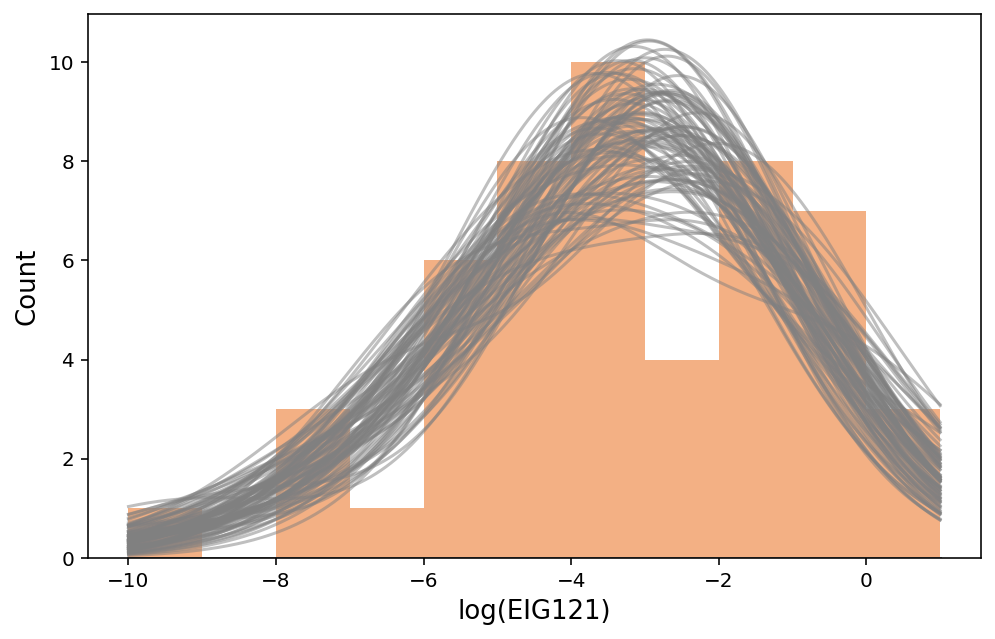

In [29]:
fig = plt.figure(figsize=(8, 5))

for f in f_acc[-100:]:
    plt.plot(x_grid, f, c="gray", alpha=0.5)
    
_ = plt.hist(y, bins=11, range=(-10, 1), color=(244/256, 177/256, 133/256))
_ = plt.xlabel("log(EIG121)", fontsize=12)
_ = plt.ylabel("Count", fontsize=12)

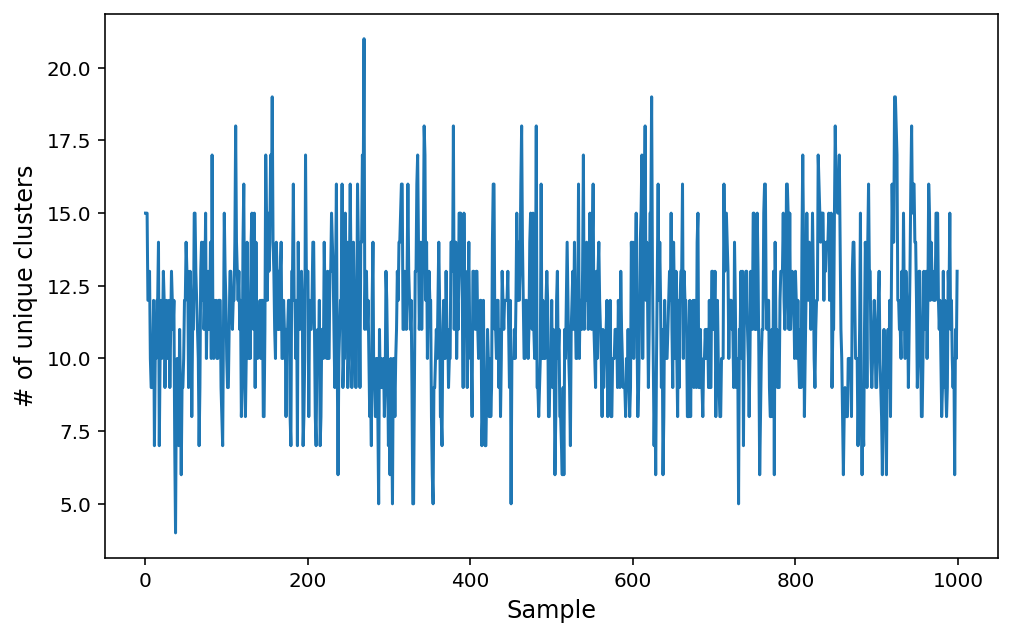

In [30]:
fig = plt.figure(figsize=(8, 5))
_ = plt.plot(range(NUM_ITER), unique_clusters)
_ = plt.xlabel("Sample", fontsize=12)
_ = plt.ylabel("# of unique clusters", fontsize=12)